# Error-Trend-Seasonality (ETS) Forecasting Methods

ETS methods are the first line of forecasting methods. They are based on the basic assumption that any timeseries data can be broken down into a level, trend, and seasonal components. These components can be broken down mathematically into three equations, one for each component. The components can be combined in multiple ways. The simplest one is additive, with multiplicative also used widely.

More detailed theory can be found in [Chapter 7](https://otexts.com/fpp2/expsmooth.html) of "Forecasting: Principles and Practice" for Rob J Hyndman and George Athanasopoulos



### Load neccessary libraries

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date
import calendar
from pandas.api.types import CategoricalDtype
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

Then load dataset.
Run the data cleaning steps we did in the previous notebook. Also add the new KPIs (DL user tput and DL cell tput)

In [3]:
df=pd.read_excel('Traffic.xlsx')

df['Start Time'] = pd.to_datetime(df['Start Time'])
df.set_index('Start Time',drop=False,inplace=True)
df['DL RBLER (%)']=df['DL RBLER (%)'].replace('NIL',np.nan)
df['DL RBLER (%)']=df['DL RBLER (%)'].astype(float)
df['DL RBLER (%)'].fillna(df['DL RBLER (%)'].median(),inplace=True)
df['DL user tput']=df['L.Thrp.bits.DL.QCI.9 (bit)']/(df['L.Thrp.Time.DL.QCI.9 (ms)']*1000)
df['DL cell tput']=df['L.Thrp.bits.DL (bit)']/(df['L.Thrp.Time.Cell.DL (s)']*1000000)

df['DL user tput']=df['DL user tput'].replace(np.nan,0)
df['DL cell tput']=df['DL cell tput'].replace(np.nan,0)

How many cells do we have in the dataset? and what is the time range we are dealing with?

In [334]:
df['Cell'].nunique()

334

In [332]:
print(df['Start Time'].min(),df['Start Time'].max())

2013-08-28 00:00:00 2013-09-04 23:45:00


we are dealing with 334 cells with a time range of one week. we have one entry every 15 minutes for each cell.

How are the cells different in terms of their number of connected users? Let's aggregate by cell and check the mean number of connected users

In [335]:
mean_users=df[['Cell','L.Traffic.User.Avg (None)']].groupby('Cell').mean().reset_index()
mean_users.sort_values('L.Traffic.User.Avg (None)', ascending=False).head(10)

,Cell,L.Traffic.User.Avg (None)
72,"Local cell identity=0, Cell Name=eNB_3410-0",117.693921
261,"Local cell identity=2, Cell Name=eNB_3167-2",116.084293
307,"Local cell identity=2, Cell Name=eNB_3525-2",115.423359
3,"Local cell identity=0, Cell Name=eNB_2151-0",112.719250
294,"Local cell identity=2, Cell Name=eNB_3401-2",109.757517
147,"Local cell identity=1, Cell Name=eNB_3167-1",109.051091
36,"Local cell identity=0, Cell Name=eNB_3167-0",101.343831
160,"Local cell identity=1, Cell Name=eNB_3186-1",98.310755
86,"Local cell identity=0, Cell Name=eNB_3808-0",90.664240
189,"Local cell identity=1, Cell Name=eNB_3524-1",88.575326


In [338]:
 print(mean_users['L.Traffic.User.Avg (None)'].min(),mean_users['L.Traffic.User.Avg (None)'].max())

13.218082031250011 117.69392057291647


There is a wide range in terms of connected users as we can see. Let's look at one cell at a time for a better picture of how the traffic behaves. After that we need to set the index frequency to 15 minutes.

In [436]:
df_filter=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_3401-2']

df_filter=df_filter.drop('Cell',axis=1)

df_filter.index.freq='15T'
df_filter.index

DatetimeIndex(['2013-08-28 00:00:00', '2013-08-28 00:15:00',
               '2013-08-28 00:30:00', '2013-08-28 00:45:00',
               '2013-08-28 01:00:00', '2013-08-28 01:15:00',
               '2013-08-28 01:30:00', '2013-08-28 01:45:00',
               '2013-08-28 02:00:00', '2013-08-28 02:15:00',
               ...
               '2013-09-04 21:30:00', '2013-09-04 21:45:00',
               '2013-09-04 22:00:00', '2013-09-04 22:15:00',
               '2013-09-04 22:30:00', '2013-09-04 22:45:00',
               '2013-09-04 23:00:00', '2013-09-04 23:15:00',
               '2013-09-04 23:30:00', '2013-09-04 23:45:00'],
              dtype='datetime64[ns]', name='Start Time', length=768, freq='15T')

Index frequency is 15 minutes as expected (15T)

Let's look at the DL user tput and number of connected users trends:

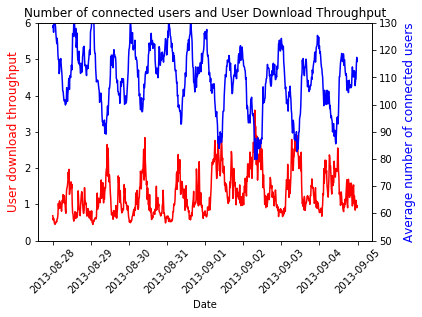

In [468]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()

plt.title('Number of connected users and User Download Throughput',fontsize=12);
# make a plot
ax.plot(
        df_filter['DL user tput'],
        color="red")

# set x-axis label
ax.set_xlabel("Date")

ax.set_xticklabels(ax.get_xticks(), rotation = 45)

# set y-axis label
ax.set_ylabel("User download throughput",
              color="red",
              fontsize=12)

ax.set_ylim(0, 6)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot( df_filter['L.Traffic.User.Avg (None)'],color="blue")
ax2.set_ylabel("Average number of connected users",color="blue",fontsize=12)
ax2.set_ylim(50, 130)


plt.show()



What do we see here? It looks clear that Dl user tput and number of connected users are inversly related. The higher the number of connected users the lower the user tput as more users are competing for the cell resources. This is intuitive.

The pearson correlation confirms this relationship

In [469]:
np.corrcoef(df_filter['DL user tput'],df_filter['L.Traffic.User.Avg (None)'])[1][0]

-0.8186259344053477

### ETS models forecasting

ETS modeling is based on decomposing the timeseries data into three components: Level, Trend, and seasonality.
Each component is modeleds separately and then all three are later combined. There are many ways to combine the three components based on the underlying components in the timerseries data itself. We will go over some details in this section

Before jumping into the details, we first need to create a framework for forecasting model evaluation. In traditional machine larning we usually use methods like train/test and cross validation. We usually do not care about the time component.
For timeseries things are different. The right way to evaluate forecasts is by training the model on an earlier subset of the data and then test it by forecasting the latter part. This can be repeated by training and testing different lags of the data to create some kind of cross validation similar to traditional machine learning. we call this method the Walk-Forward validation.

With regards to performance metrics, timeseries forecasting are continuous regression problems. We can use regression performance metrics such as R2 (R squared) and MSE (Mean Squared Error). The two metrics reveal different things and cannot replace each other. For timeseries there is a tendencay to avoid R2 as it is misleading when the variance is changing over time.

Here we first split the data into train and test sets. The test set is chosen to be the last 96 samples (accounts for one full day given the 15 minutes frequency)

In [470]:
Samtest=96
train=df_filter.iloc[:-Samtest]
test=df_filter.iloc[-Samtest:]


train_idx=df_filter.index <= train.index[-1]
test_idx=df_filter.index > train.index[-1]

The first component is the level component. This component is modeled by taking the last known value and the previous level value and combining them based on an alpha weight (smoothing level). Refer to [section 7.1](https://otexts.com/fpp2/ses.html)

In [471]:
ses=SimpleExpSmoothing(train['DL user tput'],initialization_method='legacy-heuristic')
res=ses.fit()

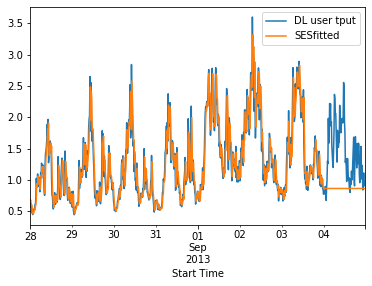

In [472]:
df_filter.loc[train_idx,'SESfitted']=res.fittedvalues #for in-sample train data
df_filter.loc[test_idx,'SESfitted']=res.forecast(Ntest) # for out-of-sample period..last 96 samples
df_filter[['DL user tput','SESfitted']].plot()

The model was trained and then forecasts generated. We can see in the plot how the forecast is simply a flat level line (SESfitted) for the forecasting period. The in-sample fitted values show that it is generally very closely following the training data. This points to an alpha value that is generally high. Let's check it

In [474]:
res.params

{'smoothing_level': 0.7464903875699221,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 0.6569988847709926,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

Alpha is around ~ 0.75. The higher the value of alpha the closer the model is to a naive forecasting model (copying the last know value).
The alpha value is optimised to minimize the Sum of Squared Error SSE

The second step in ETS forecsting is to include a trend component in the forecast. This is covered in [section 7.2](https://otexts.com/fpp2/holt.html)
The trend component has a smoothing parameter Beta

In [475]:
holt=Holt(train['DL user tput'],initialization_method='legacy-heuristic')
res_h=holt.fit()

In [476]:
df_filter.loc[train_idx,'Holt']=res_h.fittedvalues
df_filter.loc[test_idx,'Holt']=res_h.forecast(Ntest)

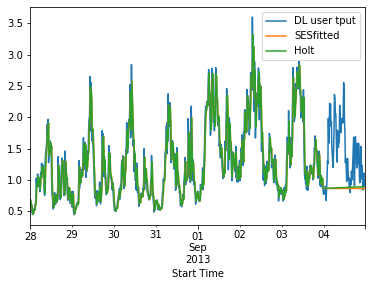

In [477]:
df_filter[['DL user tput','SESfitted','Holt']].plot()

Creating forecasts with the trend component added and the super imposed on the previous plot is shown above. We can see how the forecast with the trend component (called Holt model) is similar to the level forecast but with a slope. The slope is due to the trend component.
we can see that the trend component is very small as it's almost a flat line. This can be confirmed by checking the Beta value below which very small (smoothing_trend). Beta is also optimised to minimise SSE.

In [478]:
res_h.params

{'smoothing_level': 0.7464698566842903,
 'smoothing_trend': 2.2438635944625687e-18,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 0.6560898494292321,
 'initial_trend': 0.00030807479310959626,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

The final component to be added to the ETS model is the seasonal component. This component takes into account any cycles in the data that need to be taken into account. This component can be included in an additive or multiplicative way (same for trend BTW). This model is called the full Holt-Winters model.

As seen in the SES and HOLT models, one parameter to set is the initialization_method. A good start is to always set it to 'legacy-heuristic' as explained in  "Forecasting with Exponential Smoothing" by Hyndman et al. (2008).
Other parameters that can be set are the damped_trend, which implements the dampening trend component in [section 7.2](https://otexts.com/fpp2/holt.html#damped-trend-methods). The trend and seasonality can be combined either additive or multiplicative. We can also choose to transform the data using the box-cox transformation with the option to select lamba

In [514]:
HW=ExponentialSmoothing((train['DL user tput']),initialization_method='legacy-heuristic',damped_trend=False,trend='add',seasonal='add',use_boxcox=False,seasonal_periods=96)
res_hw=HW.fit()

Training the model and then plugging the out-of-sample forecasts and the plotting

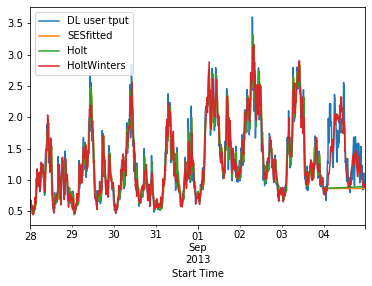

In [534]:
df_filter.loc[train_idx,'HoltWinters']=(res_hw.fittedvalues)
df_filter.loc[test_idx,'HoltWinters']=(res_hw.forecast(Ntest))
df_filter[['DL user tput','SESfitted','Holt','HoltWinters']].plot()

As compared to the level and trend models (SES and Holt), the HW model shows a very clear seasonal component (daily cycle). The model was able to track the daily trend to a good extent. Below we take a closer view to the last day that we forecast to have a better idea how close the forecasts are to the real values

In [516]:
test['HW']=(res_hw.forecast(Ntest))

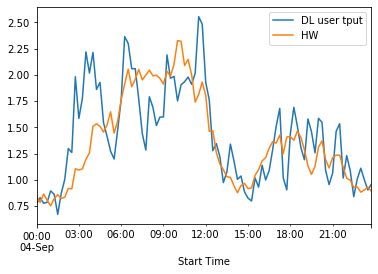

In [535]:
test[['DL user tput','HW']].plot()

The next question that comes up is how do we evaluate the model performance? And how do we pick the parameters above that gov ethe best performance?

For this we go back to the discussion regarding Walk-forward validation and performance metrics for timeseries forecasting. What we need to create right now is a framework to implement the walk-forward validation technique that allows us to pick the parameters that optimise the error metric that we choose.
Since most algorithms choose MSE as an optimisation criterion, we will start with it as our performance evaluation metric. Below is the MSE for the Holt-Winters model that we created above with the default parameters. The RMSE (square root of MSE) is 0.31 Mbps

In [525]:
np.sqrt(mean_squared_error(test['DL user tput'],test['HW']))

0.3164753657928101

Below we create a function that we can use to run the walk-forward evaluation with MSE as the criterion that we try to minimise. To do that we define the following:

h: the horizon that we forecast for. In our case it is one full day which is equivalent to 96 samples

steps: The number of shifts that we repeat to evaulate our model. In our case we do 10 shifts --> 10 runs

Samtest: This is the index that separates the train set from the test set. It depends on the length of te dataset, h, and how many steps we intend to run

we create a list of parameter combination that we would like to try. This is equivalent to hyper-parameters in machine learning. We place them in a tuple to be used in itertools library. This is done to run a gridsearch type of validation on different combinations

In [541]:
h=96
steps=10
Samtest=len(df_filter)-h-steps+1

trend_type_list=['add']
seasonal_type_list=['add','mul']
damped_trend_list=[True,False]
init_method_list=['estimated','heuristic','legacy-heuristic']
use_boxcox_list=[False,0]

tupe_of_option_lists=(
    trend_type_list,
    seasonal_type_list,
    damped_trend_list,
    init_method_list,
    use_boxcox_list   

)

In [1]:
def walkforward(trend_type,seasonal_type,damped_trend,init_method,use_boxcox,debug=False):
    """ 
    walk-forward implementation with MSE as our selection metric
    """
    errors=[]
    seen_last=False
    steps_completed=0
    
    #run the below for loop for each combination of parameters. First we use Samtest to do the train/test
    #split for each step
    
    for end_of_train in range(Samtest, len(df_filter)-h+1):
        train=df_filter.iloc[:end_of_train]
        test=df_filter.iloc[end_of_train:end_of_train+h]
        
        if test.index[-1]==df_filter.index[-1]:
            seen_last=True
            
        steps_completed +=1
        
        #HW model trained for every train set split for each set of parameters
        
        hw=ExponentialSmoothing(
        train['DL user tput'],
        initialization_method=init_method,
        trend=trend_type,
        damped_trend=damped_trend,
        seasonal=seasonal_type,
        seasonal_periods=96,
        use_boxcox=use_boxcox)
        res_hw=hw.fit()
        
        #forecasts generated and MSE is calculated everytime and appended to a list
        fcast=res_hw.forecast(h)
        error=mean_squared_error(test['DL user tput'],fcast)
        #error=r2_score(test['DL user tput'],fcast)
        errors.append(error)
        
        if debug:
            print("seen last:",seen_last)
            print("steps completed:",steps_completed)
        
        #the mean MSE is returned from the function
        return np.mean(errors)
    
    

In [531]:
best_score=float('inf')
best_options=None

#itertools used to input the tuple of parameters to the walk-forward function.

for x in itertools.product(*tupe_of_option_lists):
    score=walkforward(*x)
    
    #Best score is updated based on the mean MSE returned from walkforward function as well as the best params
    if score < best_score:
        print("Best score so far:",score)
        best_score=score
        best_options=x
        print("Best params so far:",best_options)

Best score so far: 0.11302336041992812
Best params so far: ('add', 'add', True, 'estimated', False)
Best score so far: 0.08763161083557107
Best params so far: ('add', 'add', True, 'estimated', 0)
Best score so far: 0.08759685417538295
Best params so far: ('add', 'add', True, 'legacy-heuristic', 0)


In [533]:
print("best score:",best_score)

trend_type,seasonal_type,damped_trend,init_method,use_boxcox=best_options
print("trend_type",trend_type)
print("seasonal_type",seasonal_type)
print("damped_trend",damped_trend)
print("init_method",init_method)
print("use_boxcox",use_boxcox)

best score: 0.08759685417538295
trend_type add
seasonal_type add
damped_trend True
init_method legacy-heuristic
use_boxcox 0


After running the above walk-forward validation, we get the above best params. Let's plug them in and check if we get a better RMSE. As seen from below the RMSE was not lower. The walkforward validation optimised for the mean of all 10 steps so it does not necessarily mean that it will be lower for all steps

0.3224010289575217

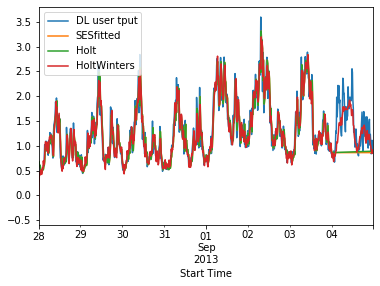

In [537]:
HW=ExponentialSmoothing((train['DL user tput']),initialization_method='legacy-heuristic',damped_trend=True,trend='add',seasonal='add',use_boxcox=0,seasonal_periods=96)
res_hw=HW.fit()

df_filter.loc[train_idx,'HoltWinters']=(res_hw.fittedvalues)
df_filter.loc[test_idx,'HoltWinters']=(res_hw.forecast(Ntest))
df_filter[['DL user tput','SESfitted','Holt','HoltWinters']].plot()

test['HW']=(res_hw.forecast(Ntest))
np.sqrt(mean_squared_error(test['DL user tput'],test['HW']))

### Different cells have different behavior

The above parameters worked well for the above cell, but would they work for all cells? Let's try another cell... "Local cell identity=2, Cell Name=eNB_3525-2" for example

In [542]:
df_filter=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_3525-2']

df_filter=df_filter.drop('Cell',axis=1)

df_filter.index.freq='15T'
df_filter.index

DatetimeIndex(['2013-08-28 00:00:00', '2013-08-28 00:15:00',
               '2013-08-28 00:30:00', '2013-08-28 00:45:00',
               '2013-08-28 01:00:00', '2013-08-28 01:15:00',
               '2013-08-28 01:30:00', '2013-08-28 01:45:00',
               '2013-08-28 02:00:00', '2013-08-28 02:15:00',
               ...
               '2013-09-04 21:30:00', '2013-09-04 21:45:00',
               '2013-09-04 22:00:00', '2013-09-04 22:15:00',
               '2013-09-04 22:30:00', '2013-09-04 22:45:00',
               '2013-09-04 23:00:00', '2013-09-04 23:15:00',
               '2013-09-04 23:30:00', '2013-09-04 23:45:00'],
              dtype='datetime64[ns]', name='Start Time', length=768, freq='15T')

In [543]:
best_score=float('inf')
best_options=None

#itertools used to input the tuple of parameters to the walk-forward function.

for x in itertools.product(*tupe_of_option_lists):
    score=walkforward(*x)
    
    #Best score is updated based on the mean MSE returned from walkforward function as well as the best params
    if score < best_score:
        print("Best score so far:",score)
        best_score=score
        best_options=x
        print("Best params so far:",best_options)

Best score so far: 0.23288932812652585
Best params so far: ('add', 'add', True, 'estimated', False)
Best score so far: 0.17959419224947795
Best params so far: ('add', 'mul', False, 'estimated', False)


In [544]:
print("best score:",best_score)

trend_type,seasonal_type,damped_trend,init_method,use_boxcox=best_options
print("trend_type",trend_type)
print("seasonal_type",seasonal_type)
print("damped_trend",damped_trend)
print("init_method",init_method)
print("use_boxcox",use_boxcox)

best score: 0.17959419224947795
trend_type add
seasonal_type mul
damped_trend False
init_method estimated
use_boxcox False


0.4043643523904968

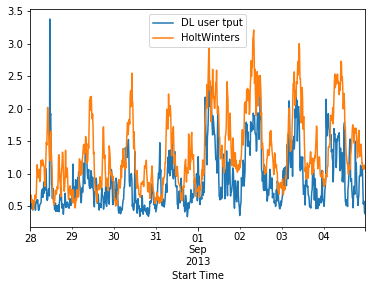

In [549]:
HW=ExponentialSmoothing((train['DL user tput']),initialization_method='estimated',damped_trend=False,trend='add',seasonal='mul',use_boxcox=False,seasonal_periods=96)
res_hw=HW.fit()

df_filter.loc[train_idx,'HoltWinters']=(res_hw.fittedvalues)
df_filter.loc[test_idx,'HoltWinters']=(res_hw.forecast(Ntest))
df_filter[['DL user tput','HoltWinters']].plot()

test['HW']=(res_hw.forecast(Ntest))
np.sqrt(mean_squared_error(test['DL user tput'],test['HW']))

Apparently not all cells behave similarily. The best params where different as well as the MSE acheived. This points ot the fact that some cells are harder to forecast as they might have less predictable traffic and user base